# Description
Detect fraud transaction in the highly unbalanced dataset.

In [61]:
import numpy as np
import pandas as pd
import random as rn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.random import set_seed

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from catboost import CatBoostClassifier

In [60]:
pip install xgboost catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.3 MB/s eta 0:00:00


In [8]:
# # Setting seeds for reproducibility
# seed(42)
# set_seed(42)

# Load and preprocess data

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
train_file_path = '/content/drive/MyDrive/Credit_Card_Fraud_Detection_2021/creditcard_train.csv'
df_train = pd.read_csv(train_file_path)

In [94]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [95]:
reduce_mem_usage(df_train)

Mem. usage decreased to 11.98 Mb (74.6% reduction)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,76460.0,1.111328,0.179688,0.531738,1.482422,-0.310303,-0.364746,0.109863,-0.052490,0.238770,...,-0.068481,0.011688,-0.038422,0.414062,0.619629,-0.334717,0.038605,0.022385,24.234375,0
1,141401.0,2.134766,0.154663,-2.054688,0.068237,0.430908,-1.839844,0.825684,-0.631836,0.183594,...,0.149292,0.591797,-0.040894,0.109192,0.442383,0.237549,-0.084839,-0.078674,2.070312,0
2,74888.0,1.219727,1.121094,-2.158203,1.545898,1.750977,0.332031,0.182617,0.222778,-0.020859,...,-0.440186,-1.002930,-0.357910,-2.117188,0.863770,-0.219360,0.093567,0.095154,1.000000,0
3,13642.0,1.219727,-0.036133,0.762695,0.121460,-0.600586,-0.365967,-0.490723,-0.019104,1.480469,...,-0.310303,-0.739746,0.106812,-0.021255,-0.015297,0.752441,-0.097961,-0.003458,18.109375,0
4,31410.0,1.192383,0.388428,0.435547,0.709961,-0.255371,-0.766602,0.081116,-0.141357,-0.141602,...,-0.227905,-0.575195,0.188110,0.386719,0.133301,0.100769,0.000401,0.032654,0.890137,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199359,137196.0,-2.777344,-2.871094,0.601074,-2.304688,0.598633,-0.266357,-0.880371,0.337646,-1.699219,...,-0.554688,-1.233398,-0.996582,0.239624,0.566895,-0.350586,0.024948,-0.854492,140.125000,0
199360,66070.0,-0.353760,0.783691,-0.031021,-1.212891,2.460938,3.365234,0.115234,0.937012,-0.520996,...,-0.282959,-0.903320,-0.061249,0.983398,-0.036438,0.086487,0.268066,0.114014,0.990234,0
199361,151913.0,-0.024475,0.601074,-0.101440,-0.673828,0.278320,-0.709473,2.160156,-0.775391,-0.316895,...,-0.130127,-0.049072,0.068848,-0.039703,-0.285889,0.370361,-0.234497,-0.244751,170.875000,0
199362,83248.0,-1.577148,1.269531,-0.686035,0.097107,0.660645,-0.944824,-0.103271,0.849121,-0.923828,...,0.023544,-0.185791,-0.365234,-0.584473,-0.222290,0.297363,0.067871,-0.066528,0.759766,0


# EDA - explorary data analys

## looking at data

In [11]:
df_train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,...,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000
mean,94912.921875,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,...,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,NaN,0.001720
std,47481.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.041443
min,0.000000,-56.406250,-72.687500,-48.312500,-5.601562,-113.750000,-26.156250,-43.562500,-73.187500,-13.320312,...,-34.843750,-9.500000,-36.656250,-2.824219,-7.496094,-2.605469,-9.898438,-15.429688,0.000000,0.000000
25%,54308.750000,-0.919434,-0.598633,-0.890625,-0.849609,-0.689941,-0.769531,-0.553711,-0.209229,-0.641602,...,-0.227783,-0.542969,-0.161133,-0.353271,-0.317383,-0.326904,-0.071106,-0.053131,5.570312,0.000000
50%,84897.500000,0.018753,0.062988,0.182739,-0.017593,-0.054977,-0.275146,0.040497,0.022118,-0.049545,...,-0.029236,0.006769,-0.010536,0.041473,0.016220,-0.052032,0.001186,0.011200,21.984375,0.000000
75%,139412.000000,1.316406,0.802246,1.026367,0.748047,0.611328,0.394775,0.569824,0.325928,0.598145,...,0.186401,0.528320,0.148193,0.440430,0.350830,0.240479,0.090942,0.078308,77.203125,0.000000
max,172792.000000,2.455078,22.062500,4.101562,16.875000,34.812500,73.312500,120.562500,20.000000,10.390625,...,27.203125,10.500000,22.078125,4.585938,6.070312,3.462891,31.609375,33.843750,25696.000000,1.000000


In [ ]:
df_train.tail()

In [15]:
# cheching if there are missed values
df_train.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [16]:
# duplicates...
df_train.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
199359    False
199360    False
199361    False
199362    False
199363    False
Length: 199364, dtype: bool

Let's check the proportion of fraud class '1'

In [96]:
# df_train['Class'].value_counts()
length = len(df_train)
count_class_1 = (df_train['Class'] == 1).sum()
pers_class_1 = count_class_1/length
print(f'class 1 represents {100*pers_class_1:.2f}% ({count_class_1} instances) of  all data {length}')

class 1 represents 0.17% (343 instances) of  all data 199364


**such big discruption in data represent a serious challage to the quality of models forecasting**

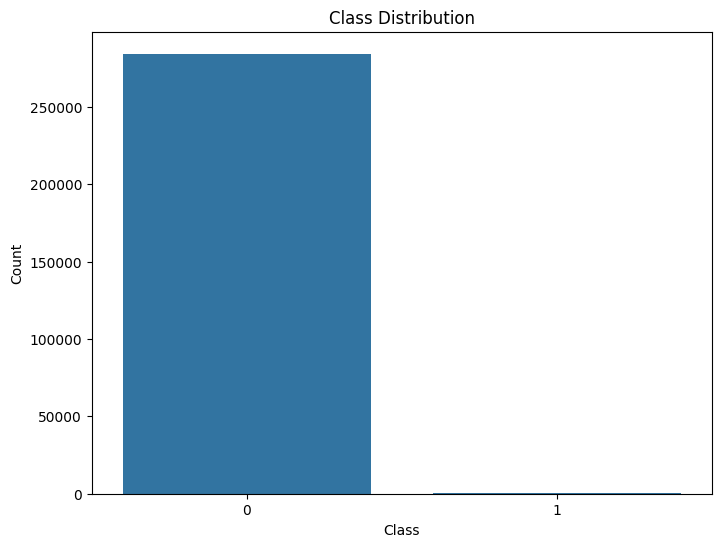

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x='Class', data=df_train)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [ ]:
# from pandas.plotting import scatter_matrix

# scatter_matrix(df_train, alpha=0.2, figsize=(27, 10), diagonal='kde')
# plt.show()

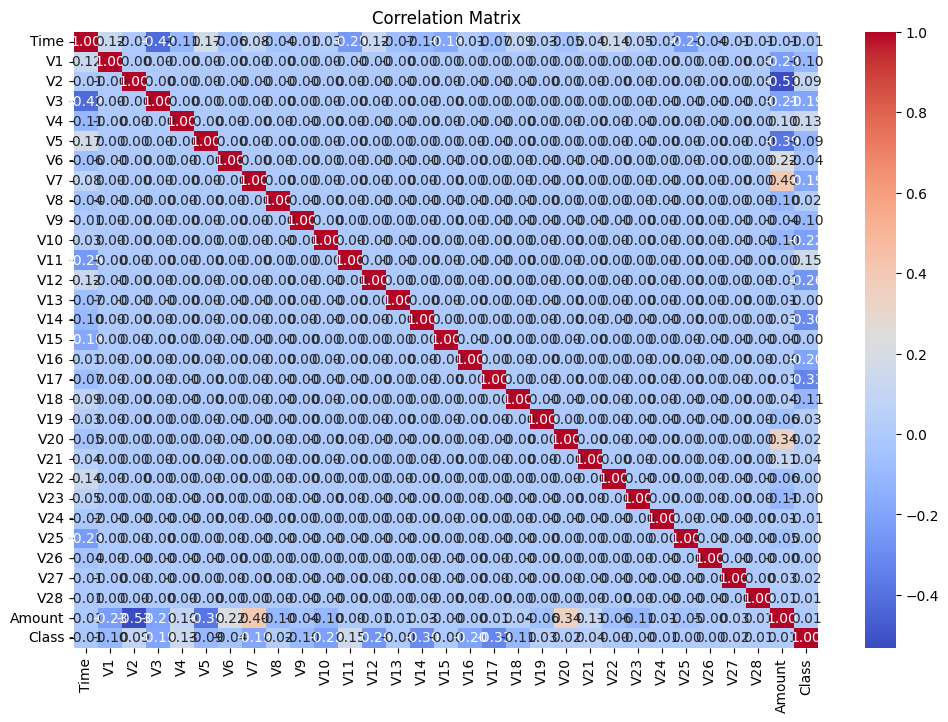

In [ ]:
# Explore the correlation between features
plt.figure(figsize=(12, 8))
correlation_matrix = df_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

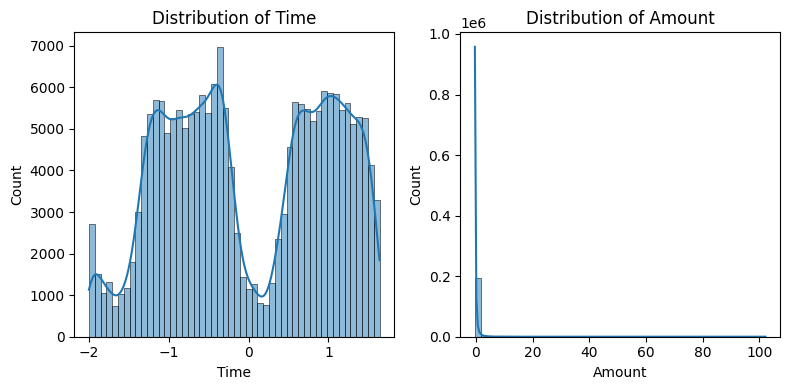

In [32]:
# Visualize the data distribution for 'Time' and 'Amount'
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.histplot(df_train['Time'], bins=50, kde=True)
plt.title('Distribution of Time')

plt.subplot(1, 2, 2)
sns.histplot(df_train['Amount'], bins=50, kde=True)
plt.title('Distribution of Amount')

plt.tight_layout()
plt.show()

Distribution of Time:

Appears to show some form of periodicity or cyclical pattern, which could be indicative of a time series dataset where events occur with some regularity over time.

Distribution of Amount:

Shows a heavily right-skewed distribution. This is common in financial data, where many small transactions are accompanied by a few large transactions.

## data transformation

scale the features above, in order to balance data range of all set

In [97]:
scaler = StandardScaler()
# Fit the scaler to the 'Time' and 'Amount' features and transform them
df_train[['Time', 'Amount']] = scaler.fit_transform(df_train[['Time', 'Amount']])

In [100]:
def preprocess_data(df):
    scaler = StandardScaler()
    df[['Time', 'Amount']] = scaler.fit_transform(df_train[['Time', 'Amount']])
    return df

In [99]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199364 entries, 0 to 199363
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    199364 non-null  float32
 1   V1      199364 non-null  float16
 2   V2      199364 non-null  float16
 3   V3      199364 non-null  float16
 4   V4      199364 non-null  float16
 5   V5      199364 non-null  float16
 6   V6      199364 non-null  float16
 7   V7      199364 non-null  float16
 8   V8      199364 non-null  float16
 9   V9      199364 non-null  float16
 10  V10     199364 non-null  float16
 11  V11     199364 non-null  float16
 12  V12     199364 non-null  float16
 13  V13     199364 non-null  float16
 14  V14     199364 non-null  float16
 15  V15     199364 non-null  float16
 16  V16     199364 non-null  float16
 17  V17     199364 non-null  float16
 18  V18     199364 non-null  float16
 19  V19     199364 non-null  float16
 20  V20     199364 non-null  float16
 21  V21     19

# TRAIN step

## define and split data

In [28]:
# Splitting the data into Features & Targets
X = df_train.drop(columns='Class', axis=1)
y = df_train['Class']

We will use **stratify=y**, parameter in the train_test_split function from scikit-learn, which ensures that the proportion of classes in the dataset is approximately maintained in both the training and the test sets.

It is crucial step in our imbalanced the dataset.

In [29]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [43]:
# initiate the model and train it
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(random_state=42)

In [44]:
# make predictions
y_pred = clf.predict(X_test)

## evaluate the model

In [45]:
# How did we do?
confusion_matrix(y_test, y_pred)

array([[39800,     4],
       [   19,    50]])

Given the imbalanced dataset with only 0.17% of the samples belonging to the positive class (1), the model correctly predicting 50 out of 69 actual positive cases is quite an achievement.


lets use more metrics

In [46]:
def print_scores(y_t, y_p):
    print(f'Accuracy  :{accuracy_score(y_t, y_p):.2f}' )
    print(f'Balanced  :{balanced_accuracy_score(y_t, y_p):.2f}' )
    print(f'F1        :{f1_score(y_t, y_p):.2f}' )
    print(f'Precision :{precision_score(y_t, y_p):.2f}' )
    print(f'Recall    :{recall_score(y_t, y_p):.2f}' )
    print(f'roc auc   :{roc_auc_score(y_t, y_p):.2f}' )
    print(f'pr)auc    :{average_precision_score(y_t, y_p):.2f}' )

In [47]:
print_scores(y_test, y_pred)

Accuracy  :1.00
Balanced  :0.86
F1        :0.81
Precision :0.93
Recall    :0.72
roc auc   :0.86
pr)auc    :0.67


## feature importance

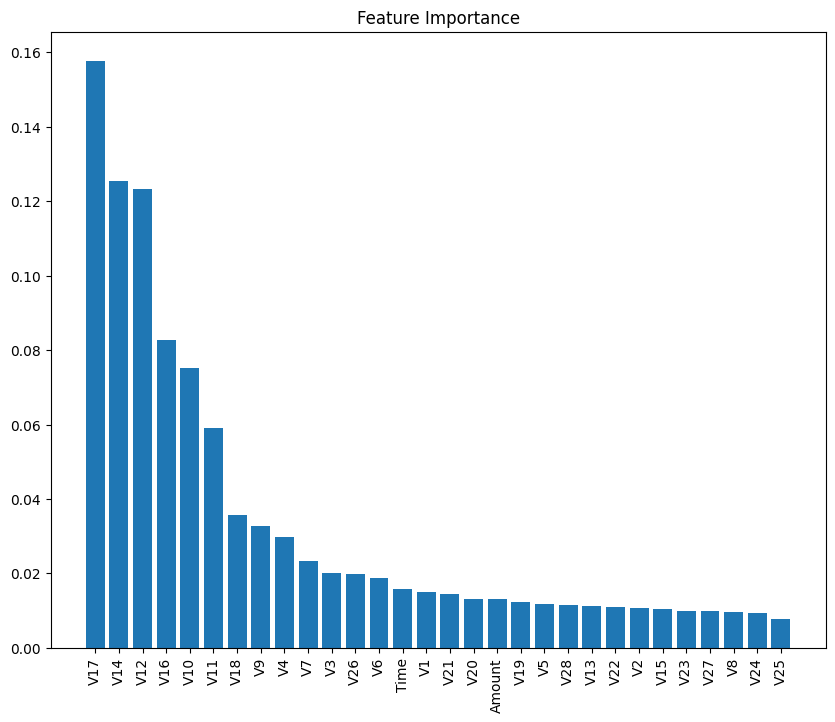

In [48]:
# extracting feature importance
importances = clf.feature_importances_

# sort them descending
indices = np.argsort(importances)[::-1]

feature_names = [X_train.columns[i] for i in indices]

# plot
plt.figure(figsize=(10, 8))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), feature_names, rotation=90)
plt.show()

are these accurate? Probably. But we can get a better picture of how are model is using our training data by trying cross validation.

## train and validate

In [74]:
#let's start over...
clf = RandomForestClassifier(n_jobs=-1,n_estimators=10, verbose=1)
# let's fit our model using cross_val_score
cvs = cross_val_score(clf, X=X_train, y=y_train, scoring='average_precision')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_j

In [75]:
print(f'Using {len(cvs)} trials:\n {cvs}')
print(f'Average:{np.mean(cvs)}')

Using 5 trials:
 [0.68069678 0.77368211 0.80101137 0.85058479 0.83166005]
Average:0.7875270182064906


In [ ]:
print_scores(y_test, y_pred)

Using 5 trials:
 [0.6421555  0.7958181  0.79542773 0.89014423 0.84960617]
Average:0.7946303476055171

and what about multiple cores

Given the class imbalance ratio, is recommended measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC).

Confusion matrix accuracy is not meaningful for unbalanced classification.

Cross validation can give better scores without using our test data. The test data we reserve to prevent overfitting.

Whats next? We can use RandomSearchCV to get the better fit for our data. But it is very expensive process.

Let's try some other popular models and see what can they do in our case.

# Other models:    

    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    'KNN': KNeighborsClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)

In [68]:
# Calculate the ratio of negative to positive samples
scale_pos_weight = sum(y == 0) / sum(y == 1)

models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(scale_pos_weight=scale_pos_weight),
    'KNN': KNeighborsClassifier(),
    'CatBoost': CatBoostClassifier(auto_class_weights='Balanced', verbose=0)
}

loop through the models, get results

In [78]:
# Prepare a list to hold the results
results_list = []

# Iterate through models, fit, predict, and calculate metrics
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    auprc = round(average_precision_score(y_test, y_pred), 2)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Append results to the list
    results_list.append({'Model': name, 'AUPRC': auprc, 'TP': tp, 'FP': fp, 'FN': fn})

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results_list)

# Display the results table
print(results_df)


               Model  AUPRC  TP  FP  FN
0      Random Forest   0.70  50   2  19
1  Gradient Boosting   0.31  29  11  40
2            XGBoost   0.71  55   7  14
3                KNN   0.63  49   6  20
4           CatBoost   0.68  56  11  13


CatBoost - AUPRC: 0.68 - very good AUPRC, highest TP, but also highest FP among models. This shows that while it is best at detecting positive cases, it does so at the cost of making more false positive errors.
But as the importance of fround is upper than the cost of not being, Cat Boost model seems to be the best from all.

XGBoost - AUPRC: 0.71 also performes effectively for detecting the positive class in this dataset.

## stack best models, using StackingClassifier

In [79]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define the base learners
estimators = [
    ('catboost', CatBoostClassifier(auto_class_weights='Balanced', verbose=0)),
    ('xgboost', XGBClassifier(scale_pos_weight=scale_pos_weight))
]

# Initialize Stacking Classifier with Logistic Regression as the meta-learner
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Fit the stacking classifier
stacking_clf.fit(X_train, y_train)
stacked_preds = stacking_clf.predict(X_test)

# Calculate metrics for the stacked model
stacked_auprc = round(average_precision_score(y_test, stacked_preds), 2)

print(f'Stacked Ensemble AUPRC: {stacked_auprc}')


Stacked Ensemble AUPRC: 0.71


## stack best models, using voting classifier, 'soft' voting method



In [83]:
from sklearn.ensemble import VotingClassifier

# Setup the models
models = [('XGBoost', XGBClassifier(scale_pos_weight=scale_pos_weight)),
    ('CatBoost', CatBoostClassifier(auto_class_weights='Balanced', verbose=0))
]

# Initialize the VotingClassifier with soft voting
ensemble_model = VotingClassifier(estimators=models, voting='soft')

# Fit the ensemble model
ensemble_model.fit(X_train, y_train)

# Optionally, predict class labels directly
ensemble_predictions = ensemble_model.predict(X_test)

# Calculate metrics for the stacked model
ensemble_auprc = round(average_precision_score(y_test, ensemble_predictions), 2)

print(f'Stacked Ensemble AUPRC: {ensemble_auprc}')


Stacked Ensemble AUPRC: 0.7


# TEST STEP


In [107]:
# load test data
test_file_path = '/content/drive/MyDrive/Credit_Card_Fraud_Detection_2021/creditcard_test.csv'
df_test = pd.read_csv(test_file_path)

In [108]:
# scaler = StandardScaler()
# Fit the scaler to the 'Time' and 'Amount' features and transform them
df_test[['Time', 'Amount']] = scaler.fit_transform(df_test[['Time', 'Amount']])

In [111]:
# predict probabilities for the test set
X_test = df_test
y_pred_test = ensemble_model.predict(X_test)

# Submission

In [112]:
submission_path = '/content/drive/MyDrive/Credit_Card_Fraud_Detection_2021/creditcard_sample_solution.csv'

sample = pd.read_csv(submission_path)

print(sample.head())
print(sample.shape)

   Id  Predicted
0   0          0
1   1          1
2   2          0
3   3          1
4   4          1
(85443, 2)


In [115]:
sample['Exited'] = y_pred_test

# save to submissions
sample.to_csv('/content/drive/MyDrive/Credit_Card_Fraud_Detection_2021/creditcard_sample_solution_ensemble.csv', index=False)

sample['Exited']

0        0
1        0
2        0
3        0
4        0
        ..
85438    0
85439    0
85440    0
85441    0
85442    0
Name: Exited, Length: 85443, dtype: int8

https://www.kaggle.com/competitions/creditcards-fraud-detection/